<font color="blue" size=5px>  This is an investigation of the data files provided by Data Glacier for week 2 of the virtual internship </font>

<font color="red" size=5px> Importing data </font>

In [1]:
#make notebook use more memory
max_buffer_size=1.2e+10

In [2]:
#use pandas to import data
import pandas as pd
CD=pd.read_csv (r'Cab_Data.csv')
Cy=pd.read_csv (r'City.csv')
CID=pd.read_csv (r'Customer_ID.csv')
TID=pd.read_csv (r'Transaction_ID.csv')


<font color="red" size=5px> Investigating the Cab_Data dataset </font>

Let's begin by getting an overview of the data:

In [3]:
print(CD.nunique()) #check number of unique values
print(CD.shape[0]) #check numbers of rows
print(CD.dtypes) #check data types
print(CD.isna().sum().sum()) #check for NA values

Transaction ID    359392
Date of Travel      1095
Company                2
City                  19
KM Travelled         874
Price Charged      99176
Cost of Trip       16291
dtype: int64
359392
Transaction ID      int64
Date of Travel      int64
Company            object
City               object
KM Travelled      float64
Price Charged     float64
Cost of Trip      float64
dtype: object
0


In [4]:
CD['Company'].value_counts() #check number of entries for each company

Yellow Cab    274681
Pink Cab       84711
Name: Company, dtype: int64

We would absolutely expect that the price charged for each trip is greater than the cost of that trip, but this is not the case. We compare whether the price charged is less than the cost of the trip for each journey for each company and sum the truth values:

In [5]:

#sum(CD['Price Charged']<CD['Cost of Trip'])
print(sum(CD['Price Charged'].where(CD['Company']=="Pink Cab")<CD['Cost of Trip']))
print(sum(CD['Price Charged'].where(CD['Company']=="Yellow Cab")<CD['Cost of Trip']))

11129
13690


This discrepancy could be explained by drivers having to wait in traffic for a long time, or undercharging, or perhaps the data is recorded incorrectly.  We don't know, so we will keep these values; if the data is valid it will be useful in the profit calculations

Let's create some box plots to visualise the numerical data, grouped by company, and identify outliers.

For the KM Travelled variable, for each company, there are no outliers:

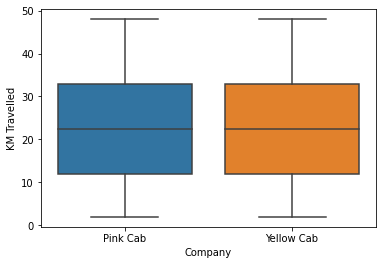

In [6]:
import seaborn as sns

KM_bp=sns.boxplot(x="Company", y="KM Travelled", data=CD)

We can see below that there are 5958 outliers for Price Charged, but we don't have a reason to believe that the information was entered incorrectly, and it's reasonable to believe that there were some longer, more expensive journeys so we will keep this data.

1149.49375
5958


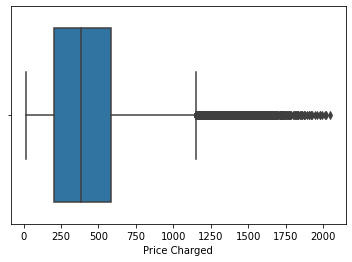

In [7]:
PC_bp= sns.boxplot(x=CD["Price Charged"])
Q3=CD['Price Charged'].quantile(0.75)
Q1=CD['Price Charged'].quantile(0.25)
IQR=Q3-Q1
upper_bound=Q3+1.5*IQR
print(upper_bound)
print(sum(CD['Price Charged']>upper_bound)) #total number of rows with Price Charged exceeding the upper bound

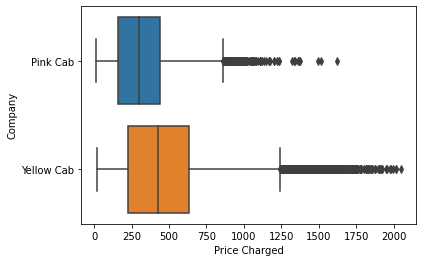

In [8]:
PC_bp= sns.boxplot(x="Price Charged",y="Company", data=CD)

The Cost of Trip variable has no outliers for each company, although there to be a similar number of outliers compared to Price Charged.

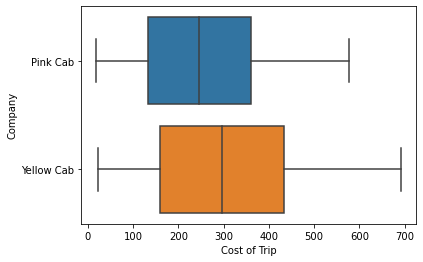

In [9]:
CT_bp= sns.boxplot(x="Cost of Trip",y="Company", data=CD)

<font color="red" size=5px> Investigating the City dataset </font>

Outliers are not meaningful for the City table, so we will not look into them here, but will explore the data in other ways

In [10]:
print(Cy.nunique())
print(Cy.shape[0])
print(Cy.dtypes) #check data types
print(Cy.isna().sum().sum()) #check for NA values

Cy = Cy.replace(',','', regex=True) #remove commas from the numbers
Cy['Users']=Cy['Users'].astype(float) #turn object into float
Cy['Population']=Cy['Population'].astype(float) #turn object into float
Cy['PPC']=Cy['Users']/Cy['Population'] #proportion of population who use cabs

City          20
Population    20
Users         20
dtype: int64
20
City          object
Population    object
Users         object
dtype: object
0


How is the number of cab users distributed between the cities?

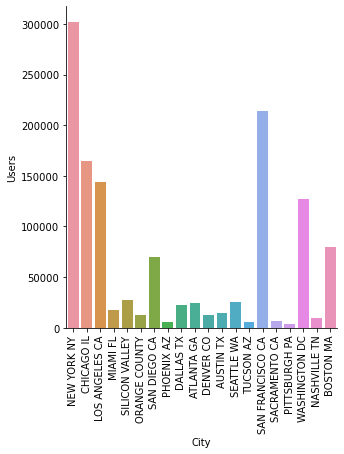

In [11]:
Cy_plot=sns.catplot(x = "City",       # x variable name
            y = "Users",       # y variable name
             # group variable name
            data = Cy,     # dataframe to plot
            kind = "bar")

for ax in Cy_plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

From the above plot, we can see that big cities are the ones with most cab users. Smaller ones such as Pittsburgh have a relatively low number of users.

How is the proportion of the number of cab users distributed between the cities?

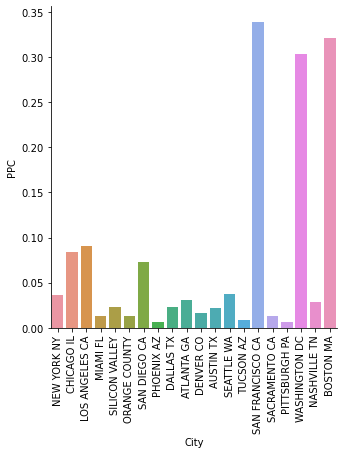

In [12]:
Cy_plot=sns.catplot(x = "City",       # x variable name
            y = "PPC",       # y variable name
             # group variable name
            data = Cy,     # dataframe to plot
            kind = "bar")
#rotate the labels for x axis
for ax in Cy_plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

<font color="red" size=5px> Investigating the Customer ID dataset </font>

In [13]:
# print(CID.nunique())
# print(CID.shape[0])
print(CID.dtypes)

Customer ID            int64
Gender                object
Age                    int64
Income (USD/Month)     int64
dtype: object


Let's investigate the number of customers, grouped by age group and gender:

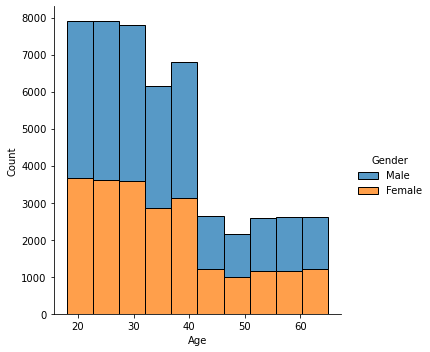

In [14]:
sns.displot(CID, x="Age", hue="Gender", bins=10, multiple="stack")

it appears that the vast majority of customers are aged between 18 and 41 years of age (approx 6500-8000 for each bin). Customers aged 41+ tend to use cabs from these companies considerably less. For each age range, there is also a roughly equal number of male and female customers.

<font color="red" size=5px> Investigating the Transaction ID dataset </font>

In [15]:
print(TID.nunique())
print(TID.shape[0])
print(TID.dtypes)

Transaction ID    440098
Customer ID        49171
Payment_Mode           2
dtype: int64
440098
Transaction ID     int64
Customer ID        int64
Payment_Mode      object
dtype: object


In [16]:
TID['Payment_Mode'].value_counts()

Card    263991
Cash    176107
Name: Payment_Mode, dtype: int64

CD lacks information for 80706 Transaction IDs, which will affect upcoming merges:

In [17]:
TID['Transaction ID'].isin(CD['Transaction ID']).value_counts()

True     359392
False     80706
Name: Transaction ID, dtype: int64

<font color="red" size=5px> Merging data </font>

We can see that there are the same number of unique Customer ID values for CID and TID. It seems logical to begin by merging CID and TID on customer ID

In [18]:
CID_TID=pd.merge(CID,TID, how='inner', on="Customer ID")
print(CID_TID.nunique())
print(CID_TID.shape[0])
#print(CID_TID)
#print(CID_TID.isnull().sum())

Customer ID            49171
Gender                     2
Age                       48
Income (USD/Month)     23341
Transaction ID        440098
Payment_Mode               2
dtype: int64
440098


Append columns of CD to CID_TID  on Transaction ID. Some rows will be lost because 80706 values are missing. 

In [19]:
CID_TID_CD=pd.merge(CID_TID,CD, on='Transaction ID', how="inner")

Now we must join Cy and CID_TID_CD to create the master data, which we will use for upcoming analyses.


In [20]:
md=pd.merge(CID_TID_CD,Cy, on='City', how="inner")

In [21]:
print(md.dtypes) #check that data types are correct

Customer ID             int64
Gender                 object
Age                     int64
Income (USD/Month)      int64
Transaction ID          int64
Payment_Mode           object
Date of Travel          int64
Company                object
City                   object
KM Travelled          float64
Price Charged         float64
Cost of Trip          float64
Population            float64
Users                 float64
PPC                   float64
dtype: object


In [22]:
import numpy as np
md = md.replace(',','', regex=True)
md['Population']=md['Population'].astype(float)
md['Users']=md['Users'].astype(float)

We find that there are no duplicate rows in this dataframe:

In [23]:
dr=md[md.duplicated()]
print(dr)

Empty DataFrame
Columns: [Customer ID, Gender, Age, Income (USD/Month), Transaction ID, Payment_Mode, Date of Travel, Company, City, KM Travelled, Price Charged, Cost of Trip, Population, Users, PPC]
Index: []


<font color="red" size=5px> Which company has maximum cab users at a particular time period? </font>

First, let's convert the serial dates to a more intuitive format:

In [24]:
import datetime
md['Date of Travel'] = pd.to_datetime((md['Date of Travel']-25569)*86400.0, unit='s' ,errors='coerce')#.dt.date


Let's group by the company name, and sample over each month for both customer IDs.

In [25]:
CID_count = md.groupby('Company').resample('M', on='Date of Travel'
               )['Customer ID'].nunique()

Convert the series into a data frame:

In [26]:
CID_count.to_frame()

Customer ID
Company    Date of Travel             
Pink Cab   2016-01-31              910
           2016-02-29             1034
           2016-03-31             1200
           2016-04-30             1210
           2016-05-31             1512
...                                ...
Yellow Cab 2018-08-31             6671
           2018-09-30             7233
           2018-10-31             7549
           2018-11-30             8371
           2018-12-31             8618

[72 rows x 1 columns]

We would like to make use of the indexes in our analysis so we must reset them:

Use the indexes as values in the rows:

In [27]:
CID_count = CID_count.reset_index(drop=False)

Remove the times to make the plot more presentable:

In [28]:
CID_count['Date of Travel'] = pd.to_datetime(CID_count['Date of Travel'], errors='coerce').dt.date

In [29]:
CID_count.shape

(72, 3)

Let's just use the values for the last annual quarter for each company in our plot

In [31]:
CID_count_tail=CID_count.groupby('Company').tail(3) #just focus on the last quarter of 2018

We see from this plot that yellow cab has over twice the number of unique customers during each month of the last quarter.

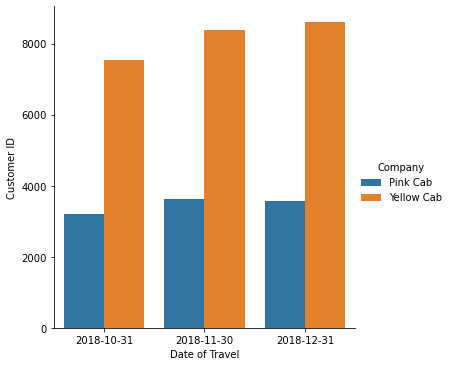

In [32]:
sns.catplot(x = "Date of Travel",       # x variable name
            y = "Customer ID",       # y variable name
            hue = "Company",  # group variable name
            data = CID_count_tail,     # dataframe to plot
            kind = "bar")

In [33]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

<font color="red" size=5px> Now, let's perform a similar analysis for transaction IDs to find the number of transactions for this time period: </font>

In [34]:
TID_count= md.groupby('Company').resample('M', on='Date of Travel' 
               )['Transaction ID'].count()

TID_count.to_frame().head()
TID_count = TID_count.reset_index(drop=False)
TID_count['Date of Travel'] = pd.to_datetime(TID_count['Date of Travel'], errors='coerce').dt.date

TID_count.columns = ['Company', 'Month end date', 'Total transactions']

In [35]:
TID_count_tail=TID_count.groupby('Company').tail(3)

We see from the plot below that yellow cab has over twice the number of transactions during each month of the last quarter.

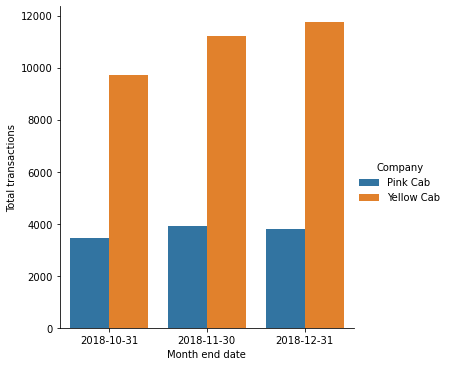

In [36]:
sns.catplot(x = "Month end date",       # x variable name
            y = "Total transactions",       # y variable name
            hue = "Company",  # group variable name
            data = TID_count_tail,     # dataframe to plot
            kind = "bar")

<font color="red" size=5px> Does margin and profit proportionally increase with increase in number of customers? </font>

First, let's create a new variable, Margin. Each row of this column represents profit for each transaction, and this column can be summed over time periods to find the total profit during that period.

In [37]:
md['Profit']=(md['Price Charged'] - md['Cost of Trip'])

Let's create some relevant features, grouped by month and company:

In [38]:
PC = md.groupby('Company').resample('M', on='Date of Travel'  #total price charged for each month
               )['Price Charged'].sum().to_frame().reset_index(drop=False) 
CT = md.groupby('Company').resample('M', on='Date of Travel' # total cost of trips
               )['Cost of Trip'].sum().to_frame().reset_index(drop=False)
M = md.groupby('Company').resample('M', on='Date of Travel' #total profit
               )['Profit'].sum().to_frame().reset_index(drop=False) 

In [39]:
print(M.head(1))
M.columns = ['Company', 'Month end date', 'Monthly Profit']
#, 'Total Price Charged', 'Total cost']

    Company Date of Travel     Profit
0  Pink Cab     2016-01-31  73952.863


In [40]:
M['Total Price Charged']=PC['Price Charged']
M['Total cost']=CT['Cost of Trip']
M['Monthly Margin']=(M['Monthly Profit']/M['Total Price Charged'])*100

In [41]:
M = pd.concat([TID_count['Total transactions'], M], axis=1)

In [42]:
# M = M.T.drop_duplicates().T

In [43]:
print(M.dtypes)

Total transactions              int64
Company                        object
Month end date         datetime64[ns]
Monthly Profit                float64
Total Price Charged           float64
Total cost                    float64
Monthly Margin                float64
dtype: object


In [44]:
print(M.dtypes)
M[['Monthly Profit','Total transactions']]=M[['Monthly Profit','Total transactions']].astype(float) #turn object into float

Total transactions              int64
Company                        object
Month end date         datetime64[ns]
Monthly Profit                float64
Total Price Charged           float64
Total cost                    float64
Monthly Margin                float64
dtype: object


From this plot and the correlation of +0.94, it is clear that the number of transactions and profit move in the same direction overall for these two cab companies

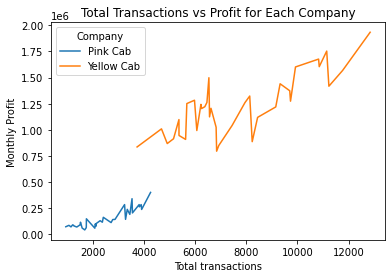

In [45]:
tt_mp=sns.lineplot(x = "Total transactions",       # x variable name
            y = "Monthly Profit",       # y variable name
            hue = "Company",  # group variable name
            data = M     # dataframe to plot
            ).set_title('Total Transactions vs Profit for Each Company')
#M.groupby('Company').sum('Monthly Profit')

In [46]:
tt_mp.figure.savefig("tt_mp.png")

In [47]:
c_pt = M['Monthly Profit'].corr(M['Total transactions'])
c_mt = M['Monthly Margin'].corr(M['Total transactions'])

In [48]:
print(c_pt, c_mt)

0.9371343079108692 0.6364445602560647


What is the overall trend between Monthly Margin and number of transactions?

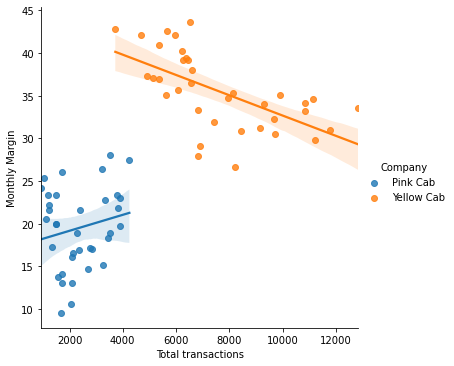

In [49]:
sns.lmplot(x='Total transactions', y='Monthly Margin', hue='Company', data=M)

For Yellow Cab, as the number of transactions increases, the Monthly Margin decreases (negative correlation). For Pink Cab, the correlation isn't very clear but it appears to be slightly positive.

<font color="red" size=5px> How much does the profit of each company per quarter compare? </font>

In [57]:
M_2 = M.groupby('Company').resample('Q', on='Month end date', convention='start')['Monthly Profit'].sum().to_frame().reset_index(drop=False)
M_2.columns = ['Company', 'Quarter end date', 'Quarterly profit']
M_2['Quarter end date'] = pd.to_datetime(M_2['Quarter end date'], errors='coerce').dt.strftime('%Y-%m')

<ipython-input-68-8bc4362040c5>:1: UserWarning: FixedFormatter should only be used together with FixedLocator
  M_2_plot=sns.lineplot(data=M_2, x="Quarter end date", y="Quarterly profit", hue="Company").set_xticklabels(labels=M_2['Quarter end date'],rotation=60)


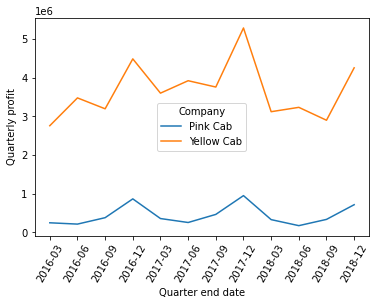

In [68]:
M_2_plot=sns.lineplot(data=M_2, x="Quarter end date", y="Quarterly profit", hue="Company").set_xticklabels(labels=M_2['Quarter end date'],rotation=60)

Yellow cab has several times the profit compared to pink cab for each quarter.

 <font color="red" size=5px>Is there seasonality in cab usage? </font>

In [63]:
S=M
S['month'] = M['Month end date'].dt.month

In [64]:
S_2 = S.groupby(['month', 'Company'])['Total transactions'].sum().to_frame().reset_index(drop=False)

<AxesSubplot:xlabel='month', ylabel='Total transactions'>

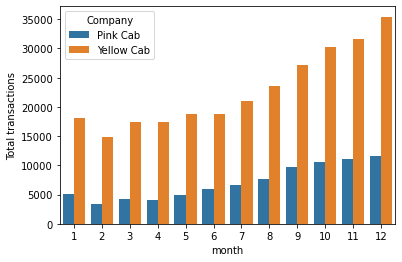

In [65]:
sns.barplot(x="month", y="Total transactions", hue="Company", data=S_2)

The general trend for both cab companies is that during later months of the year there are more transactions.

 <font color="Green" size=3px> Recommendation: it is clear from the analyses that yellow cab is considerably more profitable and has a much larger customer base than pink cab. Investing in yellow cab is considerably safer and probably more lucrative than investing in pink cab, so we could recommend investing in yellow cab.   </font>